# Problem Statement
## Objectives

The project objective is to predict the occurrence of car failure using the provided dataset for an automotive
company to formulate mitigative policies.The prediction is based on  3 car failure prediction models using datasets for car specification and measured by car sensors.



### Dataset
The dataset contains the specifications of the cars as well as parameters measured by the car sensors.

| Attribute        | Description                                                                                                                                                                                                                                                                                                                                              |
| ---------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Car ID           | Car unique ID                                                                                                                                                                                                                                                                                                                                            |
| Model            | Car model 3, 5, and 7 (in the order of increasing specifications)                                                                                                                                                                                                                                                                                        |
| Color            | Color of the car                                                                                                                                                                                                                                                                                                                                         |
| Temperature      | Average 30 days temperature of the car engine before failure detected                                                                                                                                                                                                                                                                                    |
| RPM              | Average 30 days maximum torque speed at maximum torque before failure detected                                                                                                                                                                                                                                                                           |
| Factory          | Manufacturing origin of the car                                                                                                                                                                                                                                                                                                                          |
| Usage            | Owner usage frequency of the car                                                                                                                                                                                                                                                                                                                         |
| Fuel consumption | Fuel consumption of the car in Litre per kilometre                                                                                                                                                                                                                                                                                                       |
| Membership       | Type of membership subscripted by the car owner with the automotive company.<br>“Normal” membership offers subscribers two complimentary car servicing per year.<br>“Premium” membership offers subscribers unlimited car servicing.<br>Car owners are automatically subscribed with “Normal” membership<br>for the first five years after car purchase. |
| Failure A        | A type of car failure:<br>“0” = Corresponding fault not identified,<br>“1” = Corresponding fault identified                                                                                                                                                                                                                                              |
| Failure B        | A type of car failure:<br>“0” = Corresponding fault not identified,<br>“1” = Corresponding fault identified                                                                                                                                                                                                                                              |
| Failure C        | A type of car failure:<br>“0” = Corresponding fault not identified,<br>“1” = Corresponding fault identified                                                                                                                                                                                                                                              |
| Failure D        | A type of car failure:<br>“0” = Corresponding fault not identified,<br>“1” = Corresponding fault identified                                                                                                                                                                                                                                              |
| Failure E        | A type of car failure:<br>“0” = Corresponding fault not identified,<br>“1” = Corresponding fault identified                                                                                                                                                                                                                                              |


In [864]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
import src as src
import missingno


In [865]:
failure_list = ["Failure A","Failure B", "Failure C", "Failure D", "Failure E"]
numerical_feature = ['RPM', 
    # 'Failure A', 'Failure B', 'Failure C', 'Failure D', 'Failure E', 
    'Mod_yy', 'Mod_num', 'Tem_celc', 'Color_num', 'Fac_ctry_num', 'Fac_city_num', 
    'Usage_num', 'Membership_num', 'Total_fail']


In [866]:
print(os.getcwdb)
db_path = "data/failure.db"
con = sqlite3.connect(db_path)
df = pd.read_sql_query('SELECT * from failure', con)
df.head()

<built-in function getcwdb>


,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E
0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,"Model 5, 2022",Blue,110.3 °C,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0
1,3395a182-7e76-4fb3-94ba-5163d8f4e6b0,"Model 3, 2022",Black,110.4 °C,1408,"Shang Hai, China",Medium,705.3,Premium,1,0,0,0,0
2,8c6a8e5b-d869-4665-b739-819c9e4a2070,"Model 3, 2022",Grey,110.3 °C,1498,"Shang Hai, China",Low,670.7,Premium,0,0,0,0,0
3,ff864366-fe5e-409e-9b2f-8fe440d8cc5b,"Model 3, 2022",Black,110.4 °C,1433,"Berlin, Germany",High,630.6,Premium,1,0,0,0,0
4,10484506-1be0-4a86-8dbc-b8b2092b93b2,"Model 3, 2022",White,230.7 °C,1408,"New York, U.S",High,660.9,Normal,0,1,0,0,0


# Data cleaning
## We clean rows with duplicated "Car ID", data with empty Membership, illogical data such as Negative RPM

In [867]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10081 entries, 0 to 10080
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Car ID            10081 non-null  object 
 1   Model             10081 non-null  object 
 2   Color             10081 non-null  object 
 3   Temperature       10081 non-null  object 
 4   RPM               10081 non-null  int64  
 5   Factory           10081 non-null  object 
 6   Usage             10081 non-null  object 
 7   Fuel consumption  10081 non-null  float64
 8   Membership        9697 non-null   object 
 9   Failure A         10081 non-null  int64  
 10  Failure B         10081 non-null  int64  
 11  Failure C         10081 non-null  int64  
 12  Failure D         10081 non-null  int64  
 13  Failure E         10081 non-null  int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 1.1+ MB


We notice there's some missing data in column "Membership". 
We will focus on that after removing duplicated rows.

## Clean duplicated rows
We check for duplicated rows to remove redundant data. The redundant data can lead to wrong statistical finding and low model accuracy. We found 81 rows that are duplicated and removed the respective duplicated rows.

In [868]:
df.duplicated().sum()

81

There's 81 duplicated rows. Since the unqique index should be "Car ID", let's focus on duplicated rows and sort them using index "Car ID".

In [869]:
df_dup = df[df.duplicated(keep=False)].sort_values(["Car ID"],ascending=True)
display(df_dup.head())
print(f"num of duplicated rows {len(df_dup)}")
# df_dup.drop_duplicates(keep="first", inplace=True)
# display(df_dup.head(2))
# assert len(df_dup) == len(df_dup["Car ID"].unique()), f'different lenght {len(df_dup)} != {len(df_dup["Car ID"].unique())}'
# display(df_dup[df.isna()]) #why still NA

,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E
10046,05fc6931-1619-4077-976e-26caf0f7ddab,"Model 5, 2013",Black,231.1 °F,-1679,"New York, U.S",High,697.9,Normal,0,0,0,0,0
66,05fc6931-1619-4077-976e-26caf0f7ddab,"Model 5, 2013",Black,231.1 °F,-1679,"New York, U.S",High,697.9,Normal,0,0,0,0,0
10078,0b9c5542-e343-4b7e-a4c9-aad358dbe993,"Model 3, 2019",White,110.6 °C,1529,"Shang Hai, China",Low,651.5,Normal,0,0,0,0,0
98,0b9c5542-e343-4b7e-a4c9-aad358dbe993,"Model 3, 2019",White,110.6 °C,1529,"Shang Hai, China",Low,651.5,Normal,0,0,0,0,0
10006,0d510f67-2238-4de0-9ac9-1e5a8e345622,"Model 3, 2018",Red,110.7 °C,1512,"Berlin, Germany",Low,601.2,Premium,0,0,0,0,0


num of duplicated rows 162


We found that "Car ID" "05fc6931-1619-4077-976e-26caf0f7ddab" appears twice. We will keep its first appearance and delete its duplicated rows. The same applied for other duplicated "Car ID"

In [870]:
car_id = "05fc6931-1619-4077-976e-26caf0f7ddab"
print(f"Before removing duplicated rows, num of record with Car ID {car_id}: {len(df[df['Car ID']==car_id])}")
df.drop_duplicates(keep="first", inplace=True)
print(f"After removing duplicated rows, num of record with Car ID {car_id}: {len(df[df['Car ID']==car_id])}")
df_dup = df[df.duplicated(keep=False)].sort_values(["Car ID"])
print(f"There's {len(df_dup)} dupllicated rows left")

Before removing duplicated rows, num of record with Car ID 05fc6931-1619-4077-976e-26caf0f7ddab: 2
After removing duplicated rows, num of record with Car ID 05fc6931-1619-4077-976e-26caf0f7ddab: 1
There's 0 dupllicated rows left


## Check empty data

In [871]:
print(f"num of empyt cell \n {df.isna().sum()}")

num of empyt cell 
 Car ID                0
Model                 0
Color                 0
Temperature           0
RPM                   0
Factory               0
Usage                 0
Fuel consumption      0
Membership          383
Failure A             0
Failure B             0
Failure C             0
Failure D             0
Failure E             0
dtype: int64


<AxesSubplot: >

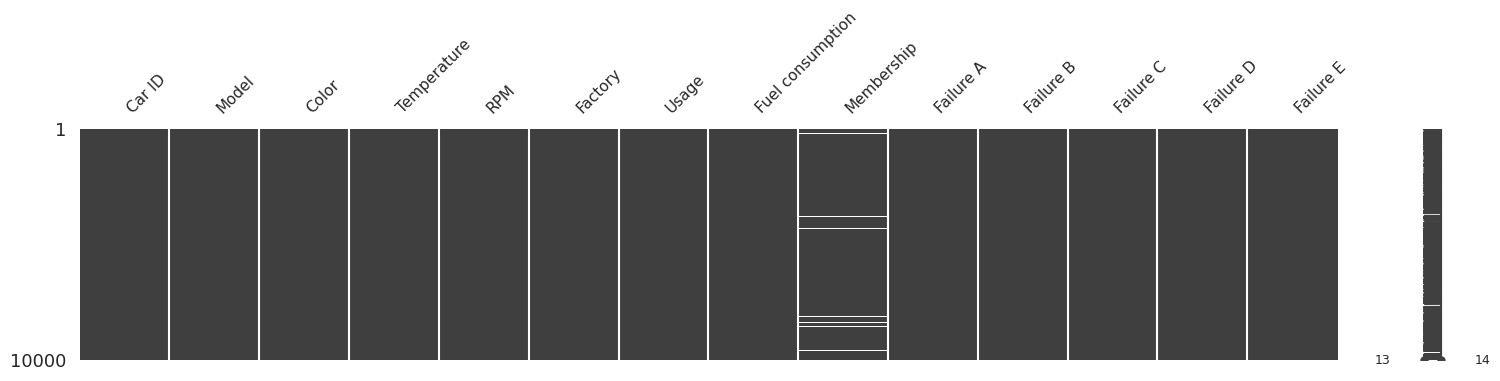

In [872]:

missingno.matrix(df, figsize=(18,3),fontsize=11)

maximum num of failure per car 1


<Figure size 640x480 with 0 Axes>

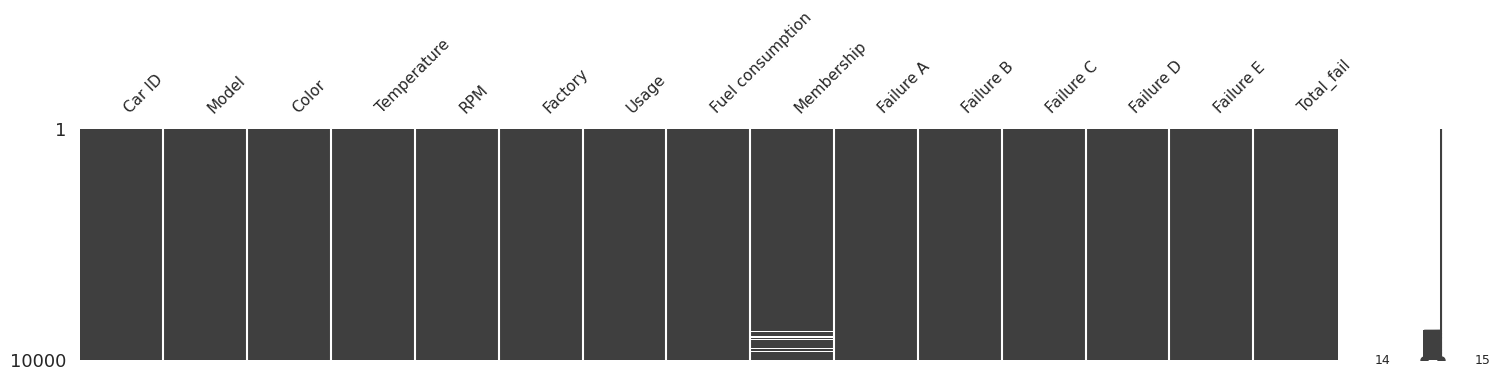

<Figure size 640x480 with 0 Axes>

In [873]:

df["Total_fail"] = df[failure_list].aggregate("sum", axis=1)
print(f"maximum num of failure per car {df.Total_fail.max()}")
missingno.matrix(df.sort_values(["Total_fail"]), figsize=(18,3),fontsize=11)
plt.figure()

In [874]:
df.sort_values(["Total_fail"]).tail()

,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Total_fail
1387,8eccda36-9735-4c0c-8d41-768a0c9cabc9,"Model 3, 2015",White,110.6 °C,1823,"Shang Hai, China",High,703.2,None,0,0,0,0,1,1
8442,99e917c1-8cd8-43d3-850c-8bcc94e391fd,"Model 3, 2022",Red,110.5 °C,1517,"Shang Hai, China",Low,625.6,Normal,0,0,0,0,1,1
1391,a431d443-c561-49c3-8cab-88312880ec3e,"Model 3, 2015",Red,231.1 °F,2737,"New York, U.S",Low,604.2,None,0,0,0,0,1,1
1335,150922c0-e35a-4ffb-8049-4b66d95701e5,"Model 3, 2011",Black,110.6 °C,1371,"Shang Hai, China",Low,687.9,None,1,0,0,0,0,1
7342,ee65ef2c-9dbb-4727-86e4-11d786ce8e37,"Model 5, 2022",White,111.0 °C,1661,"Shang Hai, China",Low,647.4,None,0,0,1,0,0,1


In [875]:
df.fillna("Empty", inplace=True)
df.isna().sum()

Car ID              0
Model               0
Color               0
Temperature         0
RPM                 0
Factory             0
Usage               0
Fuel consumption    0
Membership          0
Failure A           0
Failure B           0
Failure C           0
Failure D           0
Failure E           0
Total_fail          0
dtype: int64

White    5568
Red      1159
Blue     1129
Grey     1086
Black    1058
Name: Color, dtype: int64


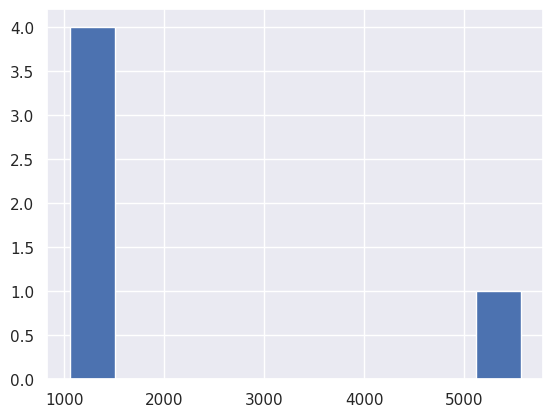

Shang Hai, China    5478
Berlin, Germany     2215
New York, U.S       2127
Seng Kang, China     106
Newton, China         44
Bedok, Germany        30
Name: Factory, dtype: int64


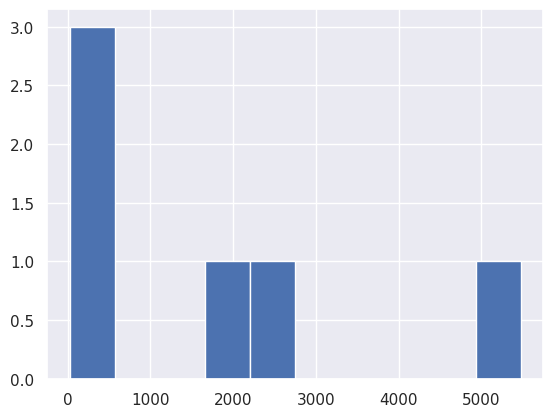

High      3527
Medium    3335
Low       3138
Name: Usage, dtype: int64


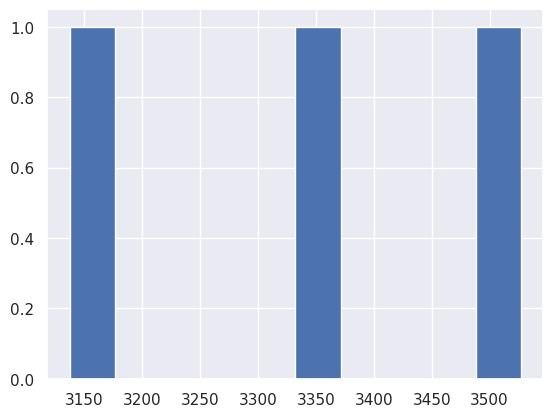

Normal     4483
Premium    3416
None       1718
Empty       383
Name: Membership, dtype: int64


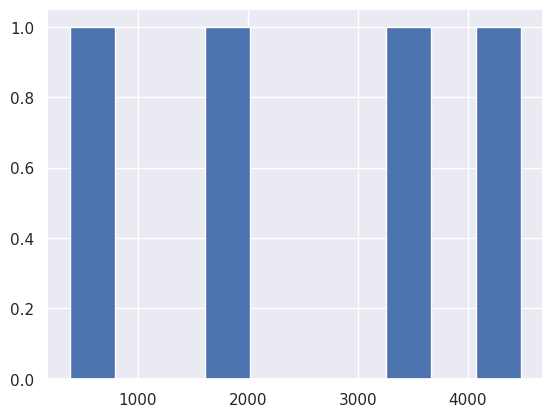

In [876]:
for col in df.drop(columns=["Car ID","Temperature", "Model"]).columns:    
    if type(df[col][0]) == str:
        print(df[col].value_counts())
        plt.hist(df[col].value_counts())
        plt.show()

## Drop rows with invalid Factory location
Remove some rows with in correct city name "Bedok, Berlin" and "Seng Kang, China" because the number of rows are small and won't affect result statistically.

In [877]:
print(df[["Factory"]].value_counts())
df = src.main.remove_wrong_city(df)

Factory         
Shang Hai, China    5478
Berlin, Germany     2215
New York, U.S       2127
Seng Kang, China     106
Newton, China         44
Bedok, Germany        30
dtype: int64
Seng Kang, China
Newton, China
Bedok, Germany


## Convert categorical data to numeric data

In [878]:
df.head()

,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Total_fail
0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,"Model 5, 2022",Blue,110.3 °C,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0,0
1,3395a182-7e76-4fb3-94ba-5163d8f4e6b0,"Model 3, 2022",Black,110.4 °C,1408,"Shang Hai, China",Medium,705.3,Premium,1,0,0,0,0,1
2,8c6a8e5b-d869-4665-b739-819c9e4a2070,"Model 3, 2022",Grey,110.3 °C,1498,"Shang Hai, China",Low,670.7,Premium,0,0,0,0,0,0
3,ff864366-fe5e-409e-9b2f-8fe440d8cc5b,"Model 3, 2022",Black,110.4 °C,1433,"Berlin, Germany",High,630.6,Premium,1,0,0,0,0,1
4,10484506-1be0-4a86-8dbc-b8b2092b93b2,"Model 3, 2022",White,230.7 °C,1408,"New York, U.S",High,660.9,Normal,0,1,0,0,0,1


In [879]:
# df, cat2num_dict = src.main.categorical_to_numerical(df)
# display(df.head())   
df["Mod_yy"]=df.Model.apply(lambda x:int(x.split(",")[-1][-2:]))
df["Mod_num"]=df.Model.apply(lambda x: int(x.split(",")[0][-1]))
df["Fac_ctry"]=df.Factory.apply(lambda x:x.split(",")[-1])
df["Fac_city"]=df.Factory.apply(lambda x:x.split(",")[0])
df["Tem_celc"]=df.Temperature.apply(
    lambda x: float(x.split(" ")[0]) if x.split(" ")[-1]=="°C" else (float(x.split(" ")[0]) - 32)*(5/9))

cat_col = ["Color",	"Fac_ctry", "Fac_city"]
cat2num_dict = {}
for col in cat_col:
    cat2num_dict[col] = sorted(list(df[col].unique()))    

cat2num_dict["Usage"] = ["Low", "Medium", "High"]
cat2num_dict["Membership"] = ["Premium", "Normal", "None", "Empty"]

for col, cat in cat2num_dict.items():
    new_col = col+"_num"
    df[new_col] = df[col].apply(lambda x: cat.index(x))
    print(f"New numerical column {new_col} and its matched value ")
    for c in cat:
        print(f"\t{cat.index(c)}:{c}")    

New numerical column Color_num and its matched value 
	0:Black
	1:Blue
	2:Grey
	3:Red
	4:White
New numerical column Fac_ctry_num and its matched value 
	0: China
	1: Germany
	2: U.S
New numerical column Fac_city_num and its matched value 
	0:Berlin
	1:New York
	2:Shang Hai
New numerical column Usage_num and its matched value 
	0:Low
	1:Medium
	2:High
New numerical column Membership_num and its matched value 
	0:Premium
	1:Normal
	2:None
	3:Empty


In [880]:
cat2num_dict["Usage"] = ['Low', 'Medium', 'High'] #incremental
cat2num_dict["Membership"] = ['Premium', 'Normal', 'None', 'Empty']
print(cat2num_dict)
print(cat2num_dict["Color"].index("Blue")) 
print(cat2num_dict["Usage"].index("High"))


{'Color': ['Black', 'Blue', 'Grey', 'Red', 'White'], 'Fac_ctry': [' China', ' Germany', ' U.S'], 'Fac_city': ['Berlin', 'New York', 'Shang Hai'], 'Usage': ['Low', 'Medium', 'High'], 'Membership': ['Premium', 'Normal', 'None', 'Empty']}
1
2


In [881]:

        
df.head()

# df.rename(columns={"Membership_num":"Mem_num"}).head()

# assert "Membership_num" in df.columns
# df.head()

,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,...,Mod_yy,Mod_num,Fac_ctry,Fac_city,Tem_celc,Color_num,Fac_ctry_num,Fac_city_num,Usage_num,Membership_num
0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,"Model 5, 2022",Blue,110.3 °C,1551,"Shang Hai, China",Medium,659.7,Normal,0,...,22,5,China,Shang Hai,110.3,1,0,2,1,1
1,3395a182-7e76-4fb3-94ba-5163d8f4e6b0,"Model 3, 2022",Black,110.4 °C,1408,"Shang Hai, China",Medium,705.3,Premium,1,...,22,3,China,Shang Hai,110.4,0,0,2,1,0
2,8c6a8e5b-d869-4665-b739-819c9e4a2070,"Model 3, 2022",Grey,110.3 °C,1498,"Shang Hai, China",Low,670.7,Premium,0,...,22,3,China,Shang Hai,110.3,2,0,2,0,0
3,ff864366-fe5e-409e-9b2f-8fe440d8cc5b,"Model 3, 2022",Black,110.4 °C,1433,"Berlin, Germany",High,630.6,Premium,1,...,22,3,Germany,Berlin,110.4,0,1,0,2,0
4,10484506-1be0-4a86-8dbc-b8b2092b93b2,"Model 3, 2022",White,230.7 °C,1408,"New York, U.S",High,660.9,Normal,0,...,22,3,U.S,New York,230.7,4,2,1,2,1


In [882]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RPM,9820.0,1470.355092,487.682432,-2636.0,1417.000,1499.0,1609.000,2886.0
Fuel consumption,9820.0,679.257037,58.363905,598.5,638.775,668.4,703.425,904.8
Failure A,9820.0,0.022912,0.149632,0.0,0.000,0.0,0.000,1.0
Failure B,9820.0,0.014766,0.120620,0.0,0.000,0.0,0.000,1.0
Failure C,9820.0,0.027189,0.162643,0.0,0.000,0.0,0.000,1.0
Failure D,9820.0,0.021690,0.145678,0.0,0.000,0.0,0.000,1.0
Failure E,9820.0,0.023625,0.151886,0.0,0.000,0.0,0.000,1.0
Total_fail,9820.0,0.110183,0.313134,0.0,0.000,0.0,0.000,1.0
Mod_yy,9820.0,16.606212,3.207306,9.0,14.000,17.0,19.000,22.0
Mod_num,9820.0,4.003870,1.343524,3.0,3.000,3.0,5.000,7.0


<AxesSubplot: >

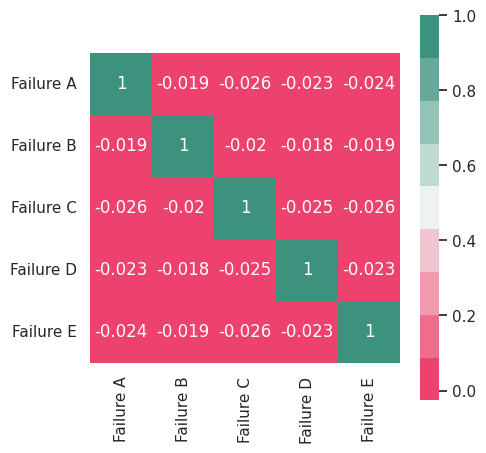

In [883]:
#Doing Bivariate Analysis by examaning a corelation matrix of all the features using heatmap
cmap = sns.diverging_palette(2, 165, s=80, l=55, n=9)
corr = df[failure_list].corr()
plt.subplots(figsize=(5,5))
sns.heatmap(corr,cmap= cmap,annot=True, square=True)

In [884]:
# # df["RPM_abs"] = df.RPM.apply(lambda x: abs(x))
# feature_drop = ['Failure A', 'Failure B', 'Failure C', 'Failure D', 'Failure E', "RPM"]
# df_total_fail = df.drop(columns=feature_drop)
# sns.pairplot(df_total_fail,hue="Total_fail")
# sns.set(font_scale=1)

<AxesSubplot: >

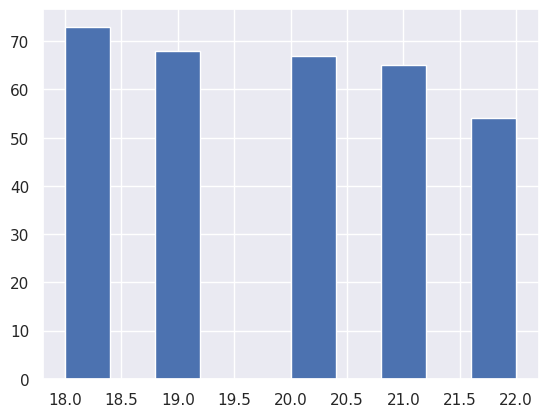

In [885]:
numerical_feature = ['RPM', 
    # 'Failure A', 'Failure B', 'Failure C', 'Failure D', 'Failure E', 
    'Mod_yy', 'Mod_num', 'Tem_celc', 'Color_num', 'Fac_ctry_num', 'Fac_city_num', 
    'Usage_num', 'Membership_num', 'Total_fail']
dfn = df[numerical_feature]
dfn[dfn.Membership_num==3]["Mod_yy"].hist()
# print(dfn[dfn.Membership_num==3]["Total_fail"])


Above chart shows cars whose membership data is empty (i.e neither "Premium, Normal, nor None") were built across year 2018 to 2022. Therefore empty membership number does not mean car which its default "Normal" membership is expired.

1082

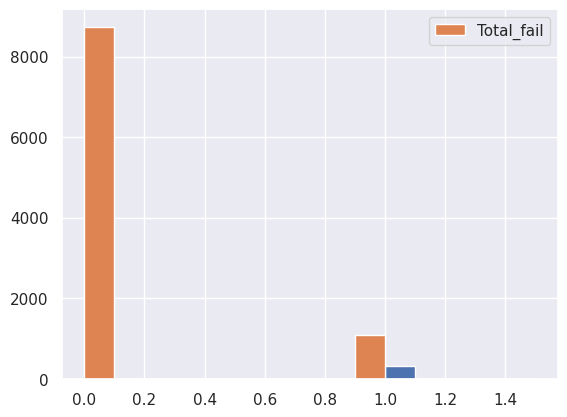

In [886]:
dfn[dfn.Membership_num==3]["Total_fail"].hist()
dfn.Total_fail.hist(legend=True)
(dfn.Total_fail == 1).sum()

In [887]:
s_scaler = sklearn.preprocessing.StandardScaler()
dfx = dfn.drop(columns=["Total_fail"], axis=1)
X_scaled = s_scaler.fit_transform(dfx)
dfx_scaled = pd.DataFrame(X_scaled, columns = numerical_feature[:-1])
dfx_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
RPM,9820.0,4.051975e-17,1.000051,-8.420570,-0.109411,0.058740,0.284308,2.902949
Mod_yy,9820.0,3.986854e-16,1.000051,-2.371647,-0.812627,0.122785,0.746393,1.681805
Mod_num,9820.0,-2.380535e-16,1.000051,-0.747229,-0.747229,-0.747229,0.741469,2.230167
Tem_celc,9820.0,1.065091e-15,1.000051,-0.667588,-0.582015,-0.368080,0.102576,25.154301
Color_num,9820.0,-1.327745e-16,1.000051,-2.025848,-0.631111,0.763625,0.763625,0.763625
Fac_ctry_num,9820.0,-2.894268e-18,1.000051,-0.812110,-0.812110,-0.812110,0.420680,1.653470
Fac_city_num,9820.0,5.064969e-18,1.000051,-1.624020,-0.405043,0.813934,0.813934,0.813934
Usage_num,9820.0,-1.215592e-16,1.000051,-1.267247,-1.267247,-0.041925,1.183396,1.183396
Membership_num,9820.0,6.403567e-17,1.000051,-1.118504,-1.118504,0.137208,0.137208,2.648631


<AxesSubplot: >

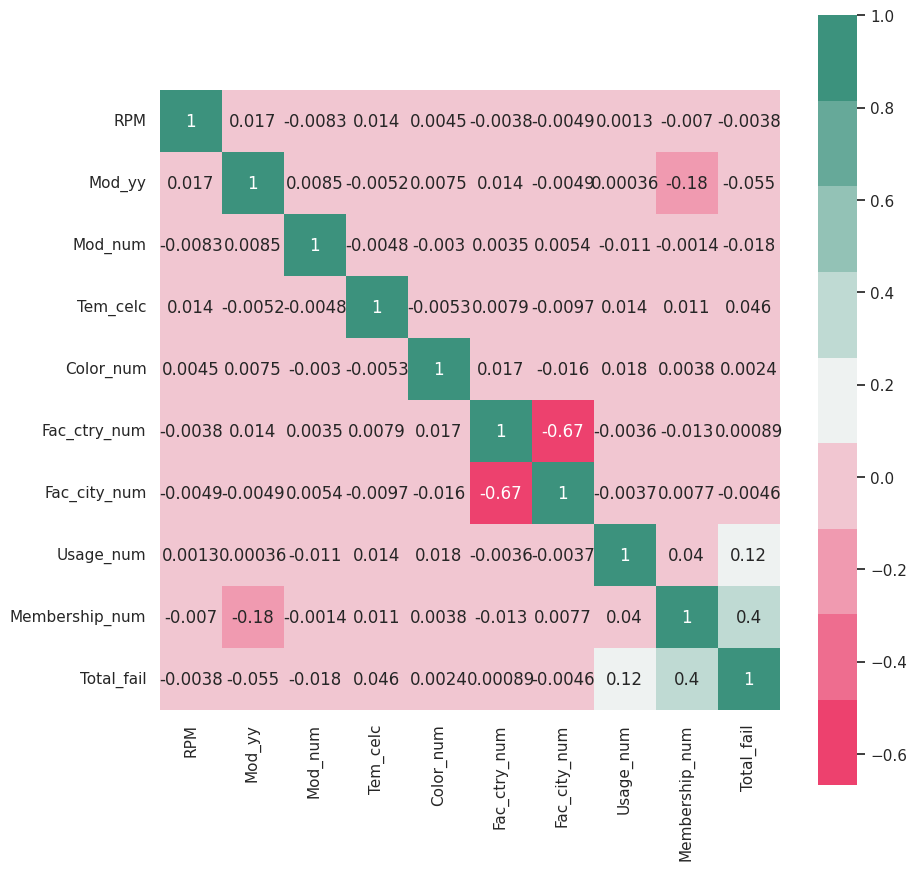

In [888]:
cmap = sns.diverging_palette(2, 165, s=80, l=55, n=9)
corr = dfn.corr()
plt.subplots(figsize=(10,10))
sns.heatmap(corr, cmap= cmap,annot=True, square=True,xticklabels=corr.columns.values, yticklabels=corr.columns.values)


### Findings
Car failure is most  correlated to "Membership", followed by "Usage", year of the "Model", "Temperature" and "RPM".
Car failure is least correlated with "Color", Factory, 



col Model
col Color
col Temperature
col Factory
col Usage
col Fuel consumption


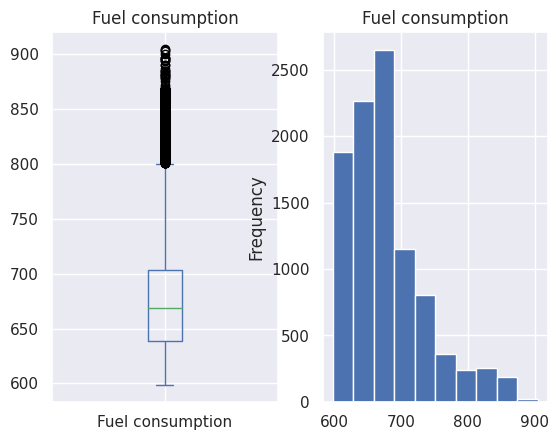

col Membership
col Total_fail


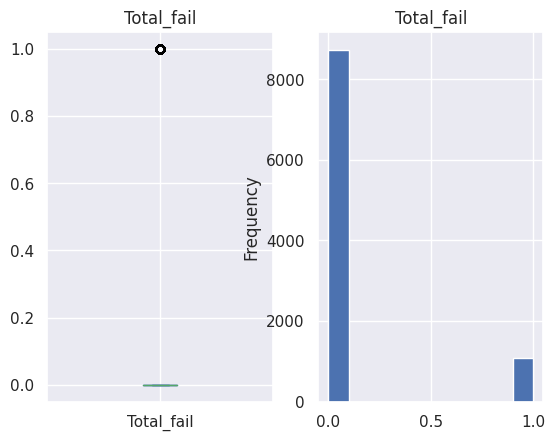

col Mod_yy


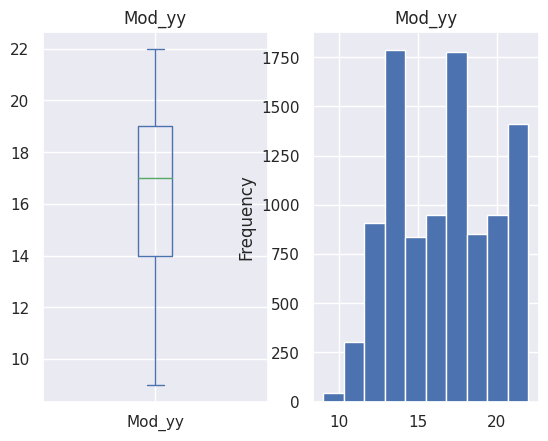

col Mod_num


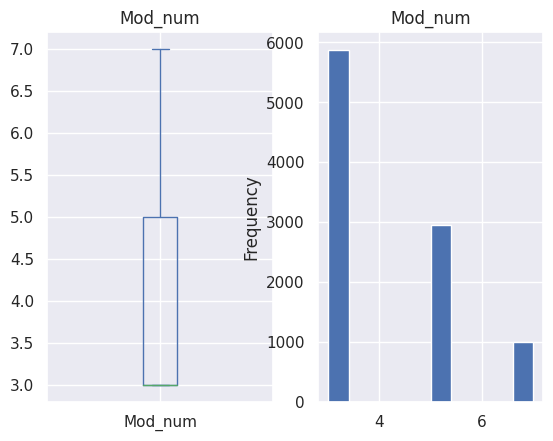

col Fac_ctry
col Fac_city
col Tem_celc


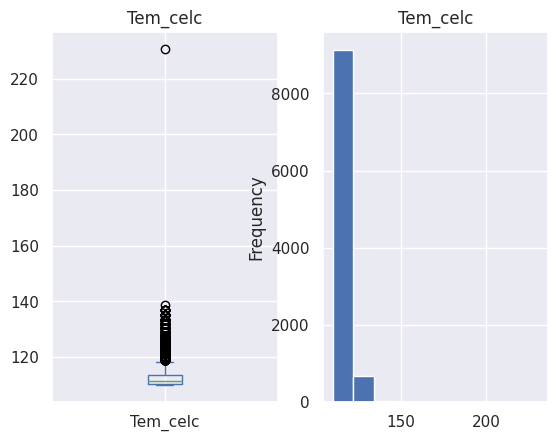

col Color_num


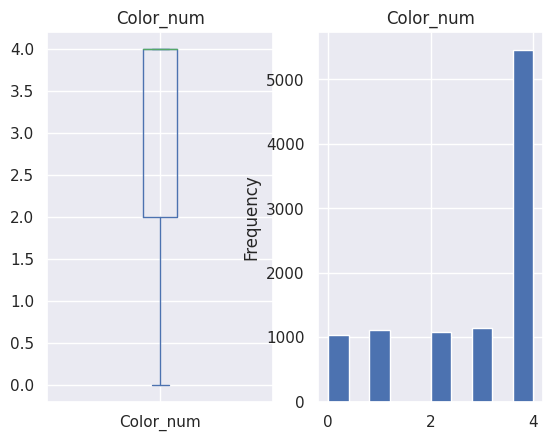

col Fac_ctry_num


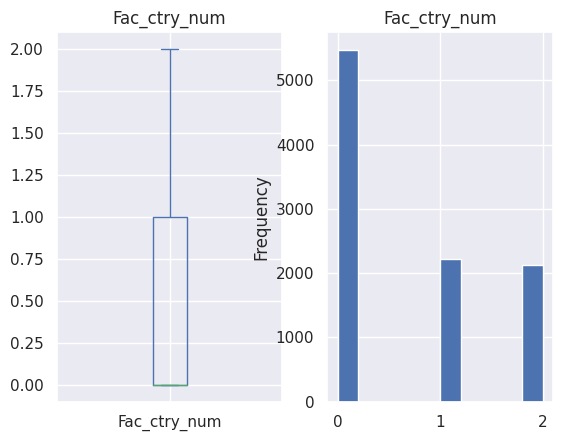

col Fac_city_num


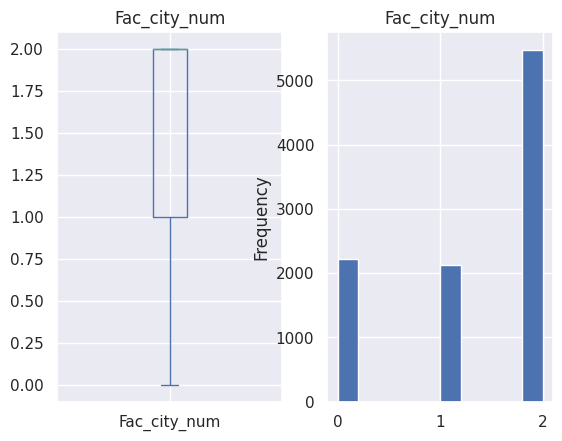

col Usage_num


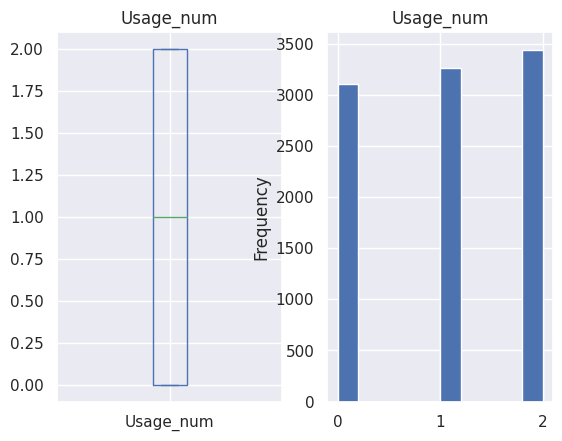

col Membership_num


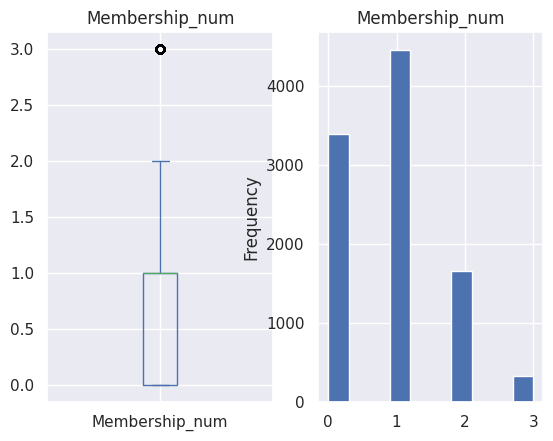

In [889]:
for col in df_total_fail.drop(columns=["Car ID"]).columns:
    print(f"col {col}")
    if (type(df_total_fail[col][0])==str) == False:
        _, ax = plt.subplots(1,2)
        plt.axes(ax[0])
        df_total_fail[col].plot.box()
        plt.title(col)

        plt.axes(ax[1])
        df_total_fail[col].plot.hist()
        plt.title(col)
        plt.show()


In [890]:
# clean_csv_path = "./data/cleaned_failure.db.csv"
# unique_index = ['Car ID']

# df[unique_index + numerical_feature].to_csv(clean_csv_path, index=False)
# print(f"saved clean data at {clean_csv_path}")
# print(f"display saved clean data with numericla columns")
# df_clean = pd.read_csv(clean_csv_path)
# display(df_clean.head())

# col = df_clean.columns
# print(col)